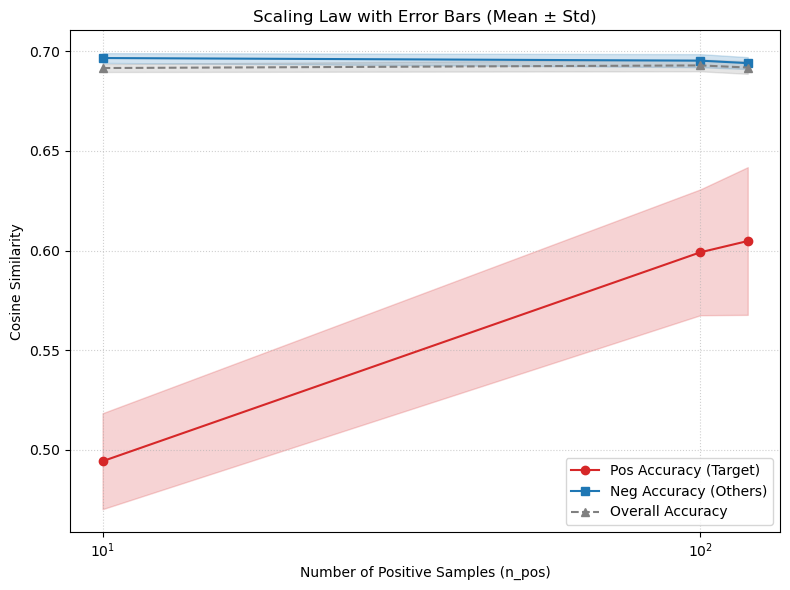

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

FLAG_COLUMN = "has_F"
TRAIN_MODE = "vanilla"  # "vanilla" or "class_balanced_loss"
VAL_METRIC = "val_loss"  # {"val_loss", "val_pos_loss"}

# 1. データの読み込み
df = pd.read_csv(f"output/csv/{FLAG_COLUMN}-{TRAIN_MODE}-esmetric={VAL_METRIC}-ae-v2.csv") 
# ※ここでは提示されたデータ形式と同じ構造を持つDataFrameがあると仮定します

# 2. 集計 (seedごとの平均と標準偏差を算出)
grouped = df.groupby("n_pos_req").agg({
    "pos_acc": ["mean", "std"],
    "neg_acc": ["mean", "std"],
    "overall_acc": ["mean", "std"]
}).reset_index()

# カラム名の整理 (pos_acc_mean, pos_acc_std ... という名前にする)
grouped.columns = ['_'.join(col).strip() if col[1] else col[0] for col in grouped.columns.values]

# 3. プロット
plt.figure(figsize=(8, 6))

x = grouped["n_pos_req"]

# --- Pos Accuracy (赤色) ---
mean = grouped["pos_acc_mean"]
std = grouped["pos_acc_std"]
plt.plot(x, mean, marker='o', color='tab:red', label='Pos Accuracy (Target)')
# ★ここで fill_between を使用
plt.fill_between(x, mean - std, mean + std, color='tab:red', alpha=0.2)

# --- Neg Accuracy (青色) ---
mean = grouped["neg_acc_mean"]
std = grouped["neg_acc_std"]
plt.plot(x, mean, marker='s', color='tab:blue', label='Neg Accuracy (Others)')
plt.fill_between(x, mean - std, mean + std, color='tab:blue', alpha=0.2)

# --- Overall Accuracy (灰色) ---
mean = grouped["overall_acc_mean"]
std = grouped["overall_acc_std"]
plt.plot(x, mean, marker='^', linestyle='--', color='gray', label='Overall Accuracy')
plt.fill_between(x, mean - std, mean + std, color='gray', alpha=0.2)

# 装飾
plt.xlabel('Number of Positive Samples (n_pos)')
plt.ylabel('Cosine Similarity')
plt.title('Scaling Law with Error Bars (Mean ± Std)')
plt.grid(True, linestyle=':', alpha=0.6)
plt.xscale('symlog', linthresh=1)
# plt.ylim(0.41, 0.77)
plt.legend()

plt.tight_layout()
# plt.savefig(f"tmp/{FLAG_COLUMN}-{TRAIN_MODE}-esmetric={VAL_METRIC}-ae.png", dpi=300)
plt.show()

In [ ]:
# 入力の分布を確認

features, mw, target = next(iter(train_loader))

# 前半 768次元 (BERT) と 後半 (フラグ) を分けて統計を見る
bert_part = features[:, :768]
flag_part = features[:, 768:]

print(f"BERT Mean: {bert_part.mean():.4f}, Std: {bert_part.std():.4f}")
print(f"BERT Min:  {bert_part.min():.4f},  Max: {bert_part.max():.4f}")
print("-" * 30)
print(f"Flag Mean: {flag_part.mean():.4f}, Std: {flag_part.std():.4f}")
print(f"Flag Min:  {flag_part.min():.4f},  Max: {flag_part.max():.4f}")